In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd "/content/gdrive/MyDrive"

/content/gdrive/MyDrive


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from gensim.models import Word2Vec

In [5]:
# Load csv file
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [6]:
# Print the number of rows and columns in the dataset
num_rows = df.shape[0]
num_columns = df.shape[1]

print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

Number of Rows: 413840
Number of Columns: 6


In [7]:
# Select part of the dataset because it's so large (around 413840 rows )
selected_data = df.sample(frac=0.95, random_state=42)
df = df.drop(selected_data.index)
len(df)

20692

In [48]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))

Summary statistics of numerical features : 
               Price        Rating  Review Votes
count  20401.000000  20692.000000  20117.000000
mean     225.629087      3.831287      1.457822
std      274.125316      1.549250      8.744494
min        1.730000      1.000000      0.000000
25%       79.950000      3.000000      0.000000
50%      141.100000      5.000000      0.000000
75%      269.100000      5.000000      1.000000
max     2408.730000      5.000000    462.000000

Total number of reviews:  20692

Total number of brands:  199

Total number of unique products:  2580

Percentage of reviews with neutral sentiment : 7.54%

Percentage of reviews with positive sentiment : 69.24%

Percentage of reviews with negative sentiment : 23.21%


Text(0, 0.5, 'Count')

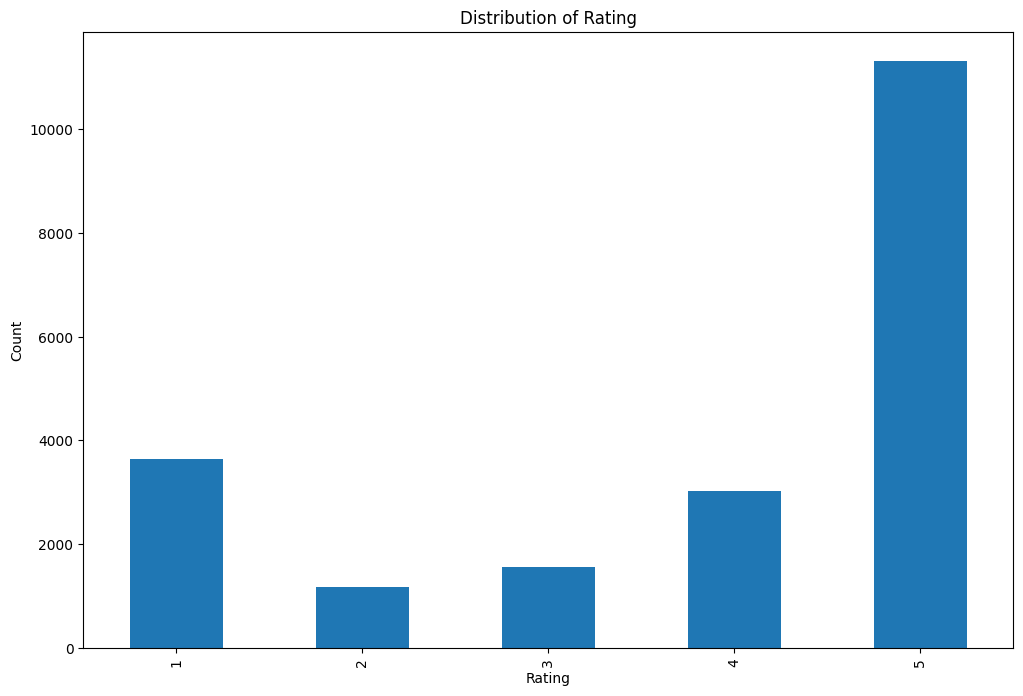

In [49]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

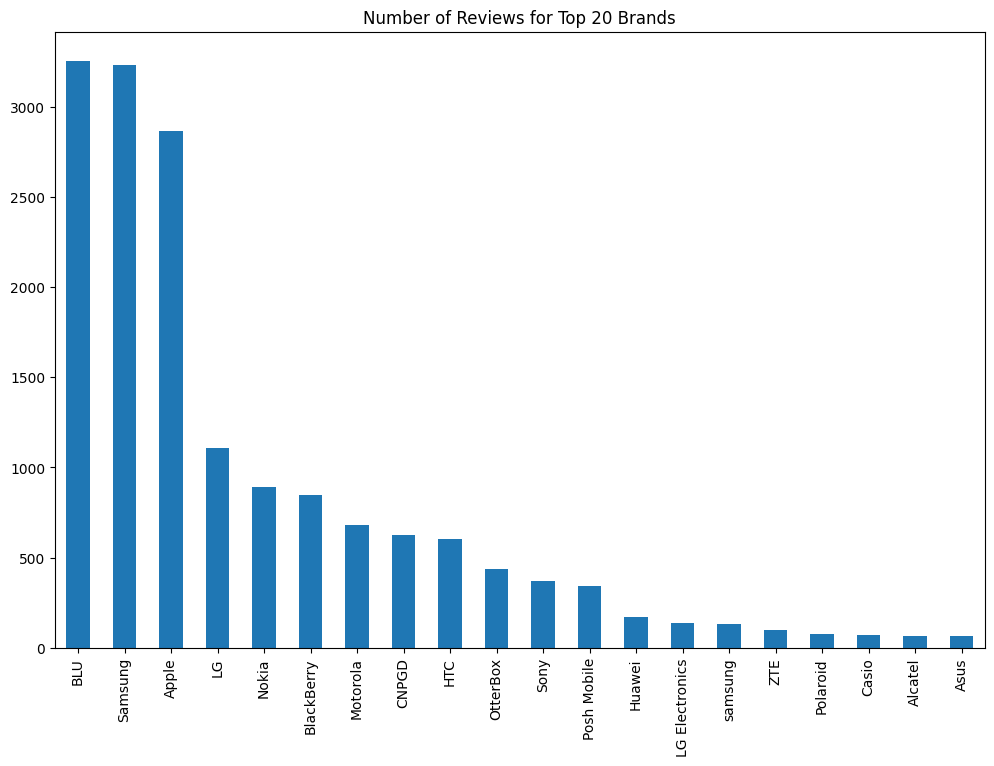

In [50]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 20 Products')

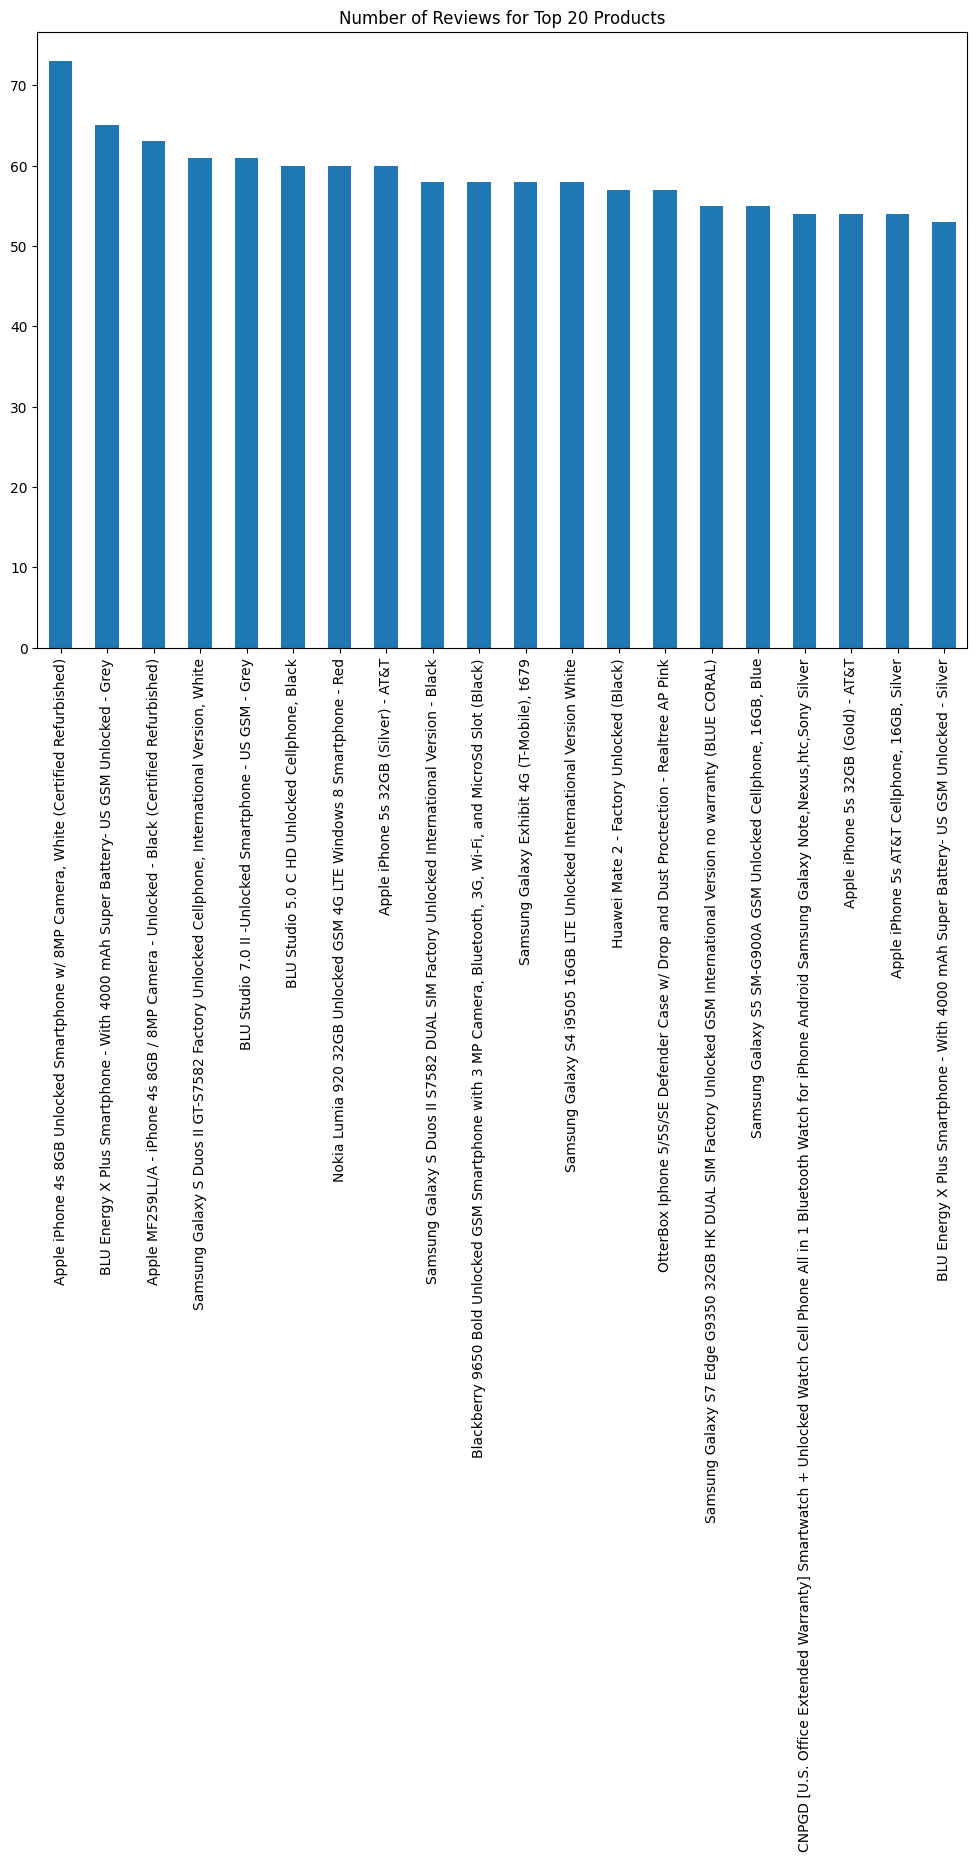

In [53]:
# Plot number of reviews for top 20 products
products = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Products")

In [8]:
# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
5,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,1,I already had a phone with problems... I know ...,1.0,0
15,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,Had this phone before and loved it but was not...,0.0,0
36,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Met all of my expectations. I can't complain a...,0.0,1
37,"""Nokia Asha 302 Unlocked GSM Phone with 3.2MP ...",Nokia,299.00,5,"Phone is working on, I was planning to use it ...",0.0,1
45,"""Nokia Asha 302 Unlocked GSM Phone with 3.2MP ...",Nokia,299.00,5,I love it!,0.0,1


In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'].values, df['Sentiment'].values, test_size=0.2, random_state=42)

In [10]:
# Tokenization
tokenizer = Tokenizer(num_words=100000)  # Consider only the top 100,000 words
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_seq_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len)

In [11]:
# Word2Vec embedding
word2vec_model = Word2Vec(sentences=X_train_seq, vector_size=128, window=5, min_count=1, workers=4)
word2vec_weights = word2vec_model.wv.vectors

In [12]:
vocab_size = word2vec_weights.shape[0]+1
# Add a zero vector to the end of the embedding matrix
word2vec_weights = np.append(word2vec_weights, np.zeros((1, word2vec_weights.shape[1])), axis=0)

In [22]:
# Model creation
model = Sequential()
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=word2vec_weights.shape[1],
        weights=[word2vec_weights],
        input_length=max_seq_len,
        trainable=False,
    )
)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# Model training
model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=64)

# Evaluating the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Epoch 1/5
194/194 [==============================] - 853s 4s/step - loss: 0.4633 - accuracy: 0.7799 - val_loss: 0.4090 - val_accuracy: 0.8113
Epoch 2/5
194/194 [==============================] - 843s 4s/step - loss: 0.3839 - accuracy: 0.8266 - val_loss: 0.3753 - val_accuracy: 0.8258
Epoch 3/5
194/194 [==============================] - 844s 4s/step - loss: 0.3468 - accuracy: 0.8429 - val_loss: 0.3309 - val_accuracy: 0.8553
Epoch 4/5
194/194 [==============================] - 842s 4s/step - loss: 0.3063 - accuracy: 0.8666 - val_loss: 0.3195 - val_accuracy: 0.8675
Epoch 5/5
97/97 [==============================] - 95s 979ms/step - loss: 0.3669 - accuracy: 0.8401
Test loss: 0.3669
Test accuracy: 0.8401


In [24]:
# # Save the trained model
# model.save("sentiment_analysis_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
#Load Model

# Import the necessary libraries
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model("sentiment_analysis_model.h5")

In [40]:
"""
Test Sample, including printing the reviews, original label and predicted label
"""

# Specify the indices of the reviews you want to print predictions for
review_indices = list(range(211, 214))

# Iterate over the specified review indices
for index in review_indices:
    # Get the test review and its corresponding label
    test_review = X_test[index]
    test_label = y_test[index]

    # Preprocess the test review
    test_review_seq = tokenizer.texts_to_sequences([test_review])
    test_review_pad = pad_sequences(test_review_seq, maxlen=max_seq_len)

    # Predict the sentiment of the test review
    predicted_prob = loaded_model.predict(test_review_pad)[0][0]

    # Convert the predicted probability to a class label
    predicted_label = 'Positive' if predicted_prob >= 0.5 else 'Negative'

    # Print the test review text and the original label from y_test
    print("Test Review:", test_review)
    print("Original Label:", test_label)
    print("Predicted Label:", predicted_label)
    print()

1/1 [==============================] - 0s 346ms/step
Test Review: Excellent Recommended works well in VENEZUELA
Original Label: 1
Predicted Label: Positive

1/1 [==============================] - 0s 280ms/step
Test Review: Excellent
Original Label: 1
Predicted Label: Positive

1/1 [==============================] - 0s 194ms/step
Test Review: After few weeks of use phone broke down, battery wasn't charging all the way, screen was freezing and several app wouldn't work. I also have some other issues that I couldn't get help solving, neither my cell phone provider or blu customer service would help me. Frustrating experience.
Original Label: 0
Predicted Label: Negative



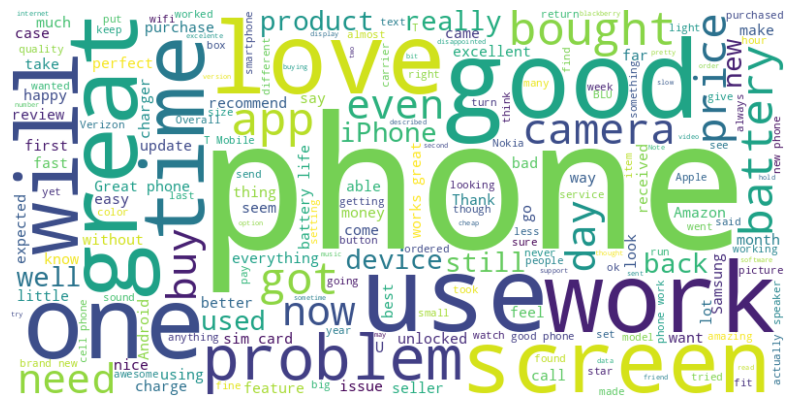

In [42]:
"""
Make Word Cloud of All the Reviews Column
"""

# Import the necessary library
from wordcloud import WordCloud

# Combine all the reviews into a single string
all_reviews = ' '.join(df['Reviews'].values)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

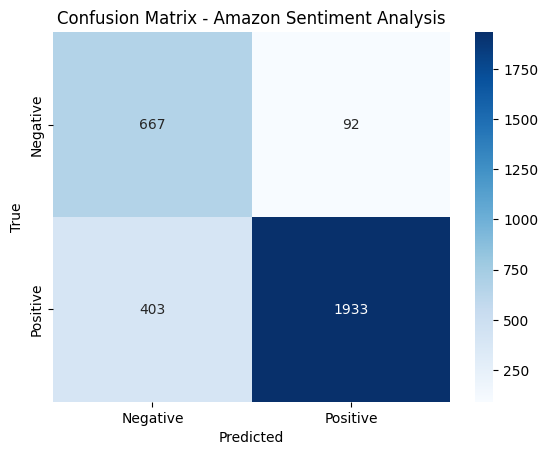

In [19]:
#Confusion Matrix
#Import Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Preprocess the test data
X_test_preprocessed = tokenizer.texts_to_sequences(X_test)
X_test_preprocessed = pad_sequences(X_test_preprocessed, maxlen=max_seq_len)

# Make predictions on the test data
y_pred = loaded_model.predict(X_test_preprocessed)
y_pred_classes = (y_pred >= 0.5).astype(int)

#Create Confusion Matrix
confusion_matrix_arr = confusion_matrix(y_test, y_pred_classes)

# Define the labels for the confusion matrix
labels = ['Negative', 'Positive']

# Convert the confusion matrix to a DataFrame
confusion_matrix_df = pd.DataFrame(confusion_matrix_arr, index=labels, columns=labels)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and formatting
plt.title('Confusion Matrix - Amazon Sentiment Analysis')
plt.xlabel('Predicted')
plt.ylabel('True')

# Display the plot
plt.show()

In [66]:
# Additional models to train if needed
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.layers import SimpleRNN

# RNN model
model_rnn = Sequential()
model_rnn.add(
    Embedding(
        input_dim=word2vec_weights.shape[0],
        output_dim=word2vec_weights.shape[1],
        weights=[word2vec_weights],
        input_length=max_seq_len,
        trainable=False,
    )
)
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# LSTM model
model_lstm = Sequential()
model_lstm.add(
    Embedding(
        input_dim=word2vec_weights.shape[0],
        output_dim=word2vec_weights.shape[1],
        weights=[word2vec_weights],
        input_length=max_seq_len,
        trainable=False,
    )
)
model_lstm.add(LSTM(128))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# GRU model
model_gru = Sequential()
model_gru.add(
    Embedding(
        input_dim=word2vec_weights.shape[0],
        output_dim=word2vec_weights.shape[1],
        weights=[word2vec_weights],
        input_length=max_seq_len,
        trainable=False,
    )
)
model_gru.add(GRU(128))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model training
model_rnn.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=64)
model_lstm.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=64)
model_gru.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=64)

# Evaluating the models
loss_rnn, accuracy_rnn = model_rnn.evaluate(X_test_pad, y_test)
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test_pad, y_test)
loss_gru, accuracy_gru = model_gru.evaluate(X_test_pad, y_test)

print(f'RNN Test loss: {loss_rnn:.4f}')
print(f'RNN Test accuracy: {accuracy_rnn:.4f}')
print(f'LSTM Test loss: {loss_lstm:.4f}')
print(f'LSTM Test accuracy: {accuracy_lstm:.4f}')
print(f'GRU Test loss: {loss_gru:.4f}')
print(f'GRU Test accuracy: {accuracy_gru:.4f}')
